In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
embedding_dim = 100
maxlen = 16
size=160000
test_split=.1
corpus = []
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

In [2]:
with open("training_cleaned.csv", encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[5])
        label=row[0]
        if label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        corpus.append(list_item)

In [3]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

In [4]:
def clean_text(sentence):
    sentence = sentence.lower()
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    sentence = pattern.sub('', sentence)
    sentence = " ".join(filter(lambda x:x[0]!='@', sentence.split()))
    emo = re.compile("["
                           u"\U0001F600-\U0001FFFF"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF" 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    sentence = emo.sub(r'', sentence)
    sentence = sentence.lower()
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)        
    sentence = re.sub(r"what's", "what is", sentence)
    sentence = re.sub(r"where's", "where is", sentence) 
    sentence = re.sub(r"\'ll", " will", sentence)  
    sentence = re.sub(r"\'ve", " have", sentence)  
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"won't", "will not",sentence)
    sentence = re.sub(r"don't", "do not", sentence)
    sentence = re.sub(r"did't", "did not", sentence)
    sentence = re.sub(r"can't", "can not", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"couldn't", "could not", sentence)
    sentence = re.sub(r"have't", "have not", sentence)
    sentence = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", sentence)
    return sentence

In [5]:
def CleanTokenize(lines):
    head_lines=[]
    for line in lines:
        line = clean_text(line)
        tokens = word_tokenize(line)
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

sentences = CleanTokenize(sentences)
sentences[0:10]

[['lol', 'guess', 'us'],
 ['great',
  'showing',
  'client',
  'making',
  'offer',
  'week',
  'mow',
  'yard',
  'clean',
  'house'],
 ['welcome'],
 ['lovin', 'friday', 'night', 'hope'],
 ['good', 'morning', 'since', 'quiet'],
 ['would', 'loooove', 'werent', 'far', 'away', 'craniums', 'shit'],
 ['need', 'exercise', 'love', 'jesus'],
 ['last',
  'day',
  'work',
  'boom',
  'start',
  'internship',
  'la',
  'never',
  'get',
  'break'],
 ['well'],
 ['dude', 'put', 'final', 'cut', 'pro', 'tell', 'stable']]

In [6]:
tokenizer = Tokenizer(oov_token="OOV")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
vocab_size=len(word_index)
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
split = int(test_split*size)
test_sequences = padded[0:split]
training_sequences = padded[split:size]
test_labels = labels[0:split]
training_labels = labels[split:size]

In [7]:
file='glove.6B.100d.txt'
glove={}
with open(file,encoding="utf8") as f:
    for line in f:
        values=line.split()
        word=values[0]
        coefs=np.asarray(values[1:],dtype='float32')
        glove[word]=coefs

In [8]:
matrix = np.zeros((vocab_size+1,embedding_dim))
for word,i in word_index.items():
    vector = glove.get(word)
    if vector is not None:
        matrix[i]=vector

In [9]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size+1,
                             embedding_dim,
                             input_length=maxlen,
                             weights=[matrix],
                             trainable=False))
model.add(tf.keras.layers.LSTM(4, dropout=0.5, recurrent_dropout=0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 100)           8642800   
                                                                 
 lstm (LSTM)                 (None, 4)                 1680      
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 8,644,485
Trainable params: 1,685
Non-trainable params: 8,642,800
_________________________________________________________________
None


In [82]:
train_padded = np.array(training_sequences)
train_labels = np.array(training_labels)
test_padded = np.array(test_sequences)
test_labels = np.array(test_labels)
history = model.fit(train_padded, train_labels, epochs=15, validation_data=(test_padded, test_labels))

Epoch 1/15
4500/4500 [==============================] - 49s 10ms/step - loss: 0.6171 - accuracy: 0.6550 - val_loss: 0.5524 - val_accuracy: 0.7198
Epoch 2/15
4500/4500 [==============================] - 46s 10ms/step - loss: 0.5824 - accuracy: 0.6927 - val_loss: 0.5418 - val_accuracy: 0.7268
Epoch 3/15
4500/4500 [==============================] - 45s 10ms/step - loss: 0.5771 - accuracy: 0.6955 - val_loss: 0.5383 - val_accuracy: 0.7262
Epoch 4/15
4500/4500 [==============================] - 46s 10ms/step - loss: 0.5732 - accuracy: 0.6990 - val_loss: 0.5385 - val_accuracy: 0.7291
Epoch 5/15
4500/4500 [==============================] - 46s 10ms/step - loss: 0.5707 - accuracy: 0.6998 - val_loss: 0.5377 - val_accuracy: 0.7283
Epoch 6/15
4500/4500 [==============================] - 46s 10ms/step - loss: 0.5699 - accuracy: 0.7028 - val_loss: 0.5360 - val_accuracy: 0.7316
Epoch 7/15
4500/4500 [==============================] - 47s 10ms/step - loss: 0.5694 - accuracy: 0.7026 - val_loss: 0.5362 -

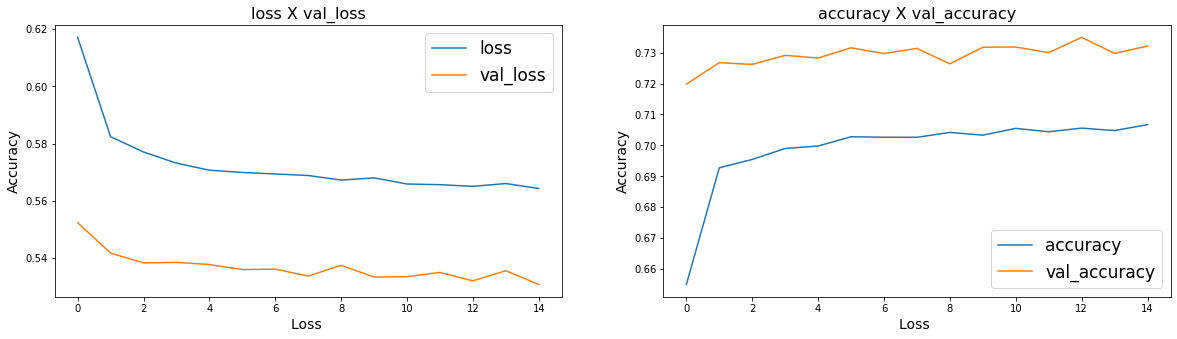

In [83]:
import matplotlib.pyplot as plt
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=17)
        ax[idx].set_xlabel('Loss ',fontsize=14)
        ax[idx].set_ylabel('Accuracy',fontsize=14)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [84]:
def predict(s):
    #x_final = pd.DataFrame({"tweet":[s]})
    lines=[]
    line = clean_text(s)
    tokens = word_tokenize(line)
#     print(tokens)
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    stop_words = set(stopwords.words("english"))
    words = [w for w in words if not w in stop_words]
    lines.append(words)
    test_sequences = tokenizer.texts_to_sequences(lines)
#     print(test_sequences)
    test_sequences=np.array(test_sequences)
#     print(test_sequences)
    test_review_pad = pad_sequences(test_sequences, maxlen=maxlen, padding='post')
    pred = model.predict(test_review_pad)
    #classes = np.argmax(pred, axis = 1)
    if pred*100 < 50:
        return 0
    else:
        return 1

In [85]:
predict("His name is Bob. He is a bad person")

1/1 [==============================] - 0s 351ms/step


0

In [99]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
tweet_data = []
words="agnipath"
number = int(input("No. of tweets you want to extract: "))
for i, tweets in enumerate(sntwitter.TwitterHashtagScraper(f'#{words} lang:en').get_items()):
    if i > number:
        break
    tweet_data.append([tweets.content, tweets.user.username])
df = pd.DataFrame(tweet_data, columns=['Tweets', 'Username'])
print(df)
filename = 'scraped_tweets.csv'
df.to_csv(filename)

No. of tweets you want to extract: 500
                                                Tweets        Username
0    @IAF_MCC @SpokespersonMoD @mygovindia @AmritMa...      BhaijiShri
1    @Dibyend70605564 @Shehzad_Ind @CinemaPyaasa Bu...  urbashidigital
2    Military aspirants, who had cleared exams unde...      IndiaToday
3    #Agniveer\n#Agnipath\n\n3rd class army of #Rus...          Sv4599
4    IAF Agnipath Recruitment 2022: More than 7.5 L...        prepp_in
..                                                 ...             ...
496  Army holds awareness cum registration drive on...          VaadeD
497  #Agniveer\n#Agnipath\n\nBCCI approaches Suprem...          Sv4599
498  Continuing with efforts towards awareness &amp...    Pluto_481298
499  #IndianArmy conducted lecture for youth of And...     JannatLolab
500  The message has gone out to India’s adversarie...   TheIndiaForum

[501 rows x 2 columns]


In [100]:
# text=df['Tweets'].values.tolist()
# usernames=df[Username]
p=list()
n=list()
for i in range(len(df)):
    t=predict(df.loc[i,"Tweets"])
    print(t)
    if t==1:
        p.append(df.loc[i,"Username"])
        #print(df.loc[i,"Username"])
    else:
        n.append(df.loc[i,"Username"])

1/1 [==============================] - 0s 31ms/step
1
1/1 [==============================] - 0s 32ms/step
1
1/1 [==============================] - 0s 32ms/step
1
1/1 [==============================] - 0s 32ms/step
1
1/1 [==============================] - 0s 28ms/step
1
1/1 [==============================] - 0s 34ms/step
0
1/1 [==============================] - 0s 29ms/step
1
1/1 [==============================] - 0s 31ms/step
1
1/1 [==============================] - 0s 32ms/step
1
1/1 [==============================] - 0s 35ms/step
1
1/1 [==============================] - 0s 37ms/step
1
1/1 [==============================] - 0s 30ms/step
0
1/1 [==============================] - 0s 34ms/step
0
1/1 [==============================] - 0s 37ms/step
1
1/1 [==============================] - 0s 35ms/step
1
1/1 [==============================] - 0s 34ms/step
0
1/1 [==============================] - 0s 25ms/step
0
1/1 [==============================] - 0s 28ms/step
1
1/1 [=======================

In [34]:
# import snscrape.modules.twitter as sntwitter
# import pandas as pd
# tweet_data = []
# number = 500
# for i, tweets in enumerate(sntwitter.TwitterSearchScraper('{}'.format(username)).get_items()):
#     if i > number:
#         break
#     tweet_data.append([tweets.date, tweets.content, tweets.user.username, tweets.url])
#     db = pd.DataFrame(tweet_data, columns=['Date', 'Tweets', 'Username', 'url'])
# print(db)
# def scrape(username):
#     pos=0
#     neg=0
#     import tweepy
#     consumer_key = "D5QKTDSY7LnB0HrZXEquBJIpA"
#     consumer_secret = "za3WphGqvr0rgUL69ocyHELavCnKAfXfjhA54RV8jCL2lWa1w4"
#     access_key = "1226379496489504769-MS9QIlv7rWJWDvI4awzDMrCNSYFdHh"
#     access_secret = "GP5rFSbjeCZZgesgss8OEXz0yrRpROuyPzFNTYJvsyp7K"
#     auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
#     auth.set_access_token(access_key, access_secret)
#     api = tweepy.API(auth)
#     date_since = "2022-07--01"
#     numtweet = 10
#     username="@"+username
#     search_tags = ['BJP','narendramodi']
#     for tweet in tweepy.Cursor(api.user_timeline, screen_name=username, tweet_mode='extended').items():
#         if len(tweet._json['entities']['hashtags']) > 0:
#             tweet_hashtags = [hashtag['text'] for hashtag in tweet._json['entities']['hashtags'] if hashtag['text'] in search_tags]
#             if(len(tweet_hashtags)>0):
#                 g=predict(tweet._json['full_text'])
#                 if g==1:
#                     pos=pos+1
#                 else:
#                     neg=neg+1
#     if pos==0 & neg==0:
#         return 0
#     if pos/(pos+neg) > 0.7:
#         return 1
#     elif neg/(pos+neg) > 0.7:
#         return -1
#     else:
#         return 0

In [101]:
def scrape(username):
    tweet_data = []
    hashtags=['BJP','NarendraModi']
    # username = input("Enter your keyword:")
    number = 50
    pos=0
    neg=0
    for i, tweets in enumerate(sntwitter.TwitterUserScraper('{}'.format(username)).get_items()):
        if i>number:
            break
        for j in hashtags:
            if re.search(j,tweets.content): 
                g=predict(tweets.content)
                if g==1:
                    pos=pos+1
                else:
                    neg=neg+1
                break
    if pos==0 & neg==0:
        return 0
    if pos/(pos+neg) > 0.5:
        return 1
    elif neg/(pos+neg) > 0.5:
        return -1
    else:
        return 0 
    # df = pd.DataFrame(tweet_data, columns=['Date', 'Tweets', 'Username', 'url'])
    # print(df)

In [102]:
change_p=list()
change_n=list()

for i in np.array(np.unique(p)):
    tmp=scrape(i)
    if tmp==-1:
        change_n.append(i)
for i in np.array(np.unique(n)):
    tmp=scrape(i)
    if tmp==1:
        change_p.append(i)


1/1 [==============================] - 0s 22ms/step


In [109]:
p=np.array(np.unique(p))
n=np.array(np.unique(n))
print("Negative change-")
print(len(change_n)/p.size)
print("Positive change-")
print(len(change_p)/n.size)
print("Percentage supporting-")
print(len(p)/(len(p)+len(n)))
print("Percentage against-")
print(len(n)/(len(p)+len(n)))

Negative change-
0.0755813953488372
Positive change-
0.19444444444444445
Percentage supporting-
0.6142857142857143
Percentage against-
0.38571428571428573
